In [1]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2
import utils

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [2]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in /home/csirlin/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [3]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
image_path = "depth.jpg"  # Change to your image path
img = Image.open(image_path)
depth = zoe.infer_pil(img)
img = np.array(img)

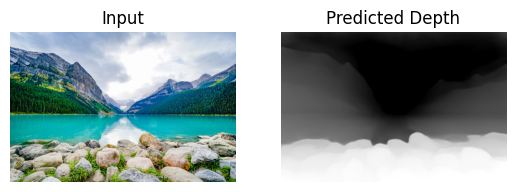

In [4]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

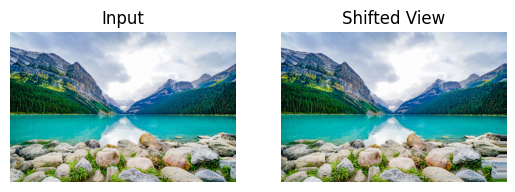

In [5]:
# compute shifted image
warped_image = utils.compute_right_eye(img, depth, 60, shift=0.063)

fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

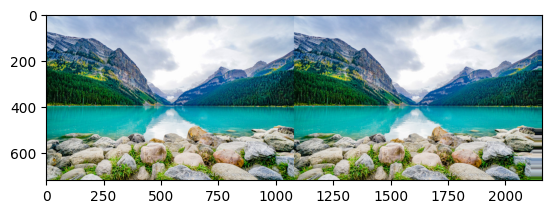

In [6]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)
# im = Image.fromarray(img_and_warped)
# im.save("../output.jpeg")

In [ ]:
### pulse2percept time ###
scoreboard = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
scoreboard.build()

axon_left = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="LE")
axon_left.build()

axon_right = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="RE")
axon_right.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=500, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.5, 1.5), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=4, ndim=[2], noise=None, rho=200, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             vfmap=Watson2014Map(ndim=2), xrange=(-12, 12), 
             xystep=0.1, yrange=(-12, 12))

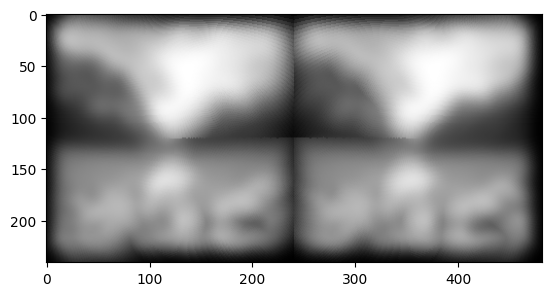

In [21]:
big_prosthetic_left = utils.get_big_prosthesis("LE")
big_prosthetic_right = utils.get_big_prosthesis("RE")
big_percept_left = utils.get_percept_data_from_image(img, axon_left, big_prosthetic_left)
big_percept_right = utils.get_percept_data_from_image(warped_image, axon_right, big_prosthetic_right)

# idealized percepts still have the effect!
percept_side_by_side = np.hstack((big_percept_left, big_percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

In [32]:
argus_left = p2p.implants.ArgusII(eye="LE")
argus_right = p2p.implants.ArgusII(eye="RE")
argus_percept_left = utils.get_percept_data_from_image(img, axon_left, argus_left)
argus_percept_right = utils.get_percept_data_from_image(img, axon_right, argus_right)

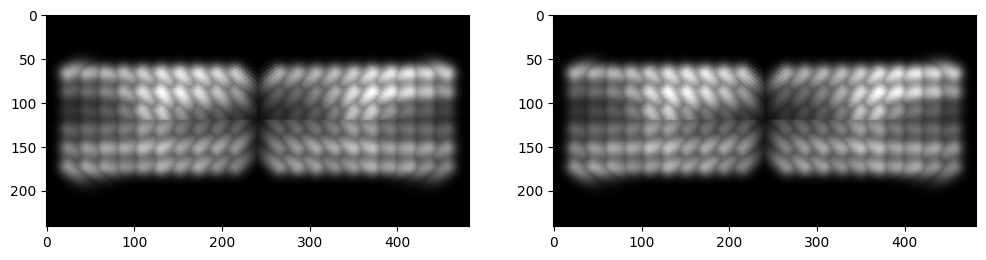

In [122]:
# now try argus II
axon_left_diff = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="LE")
axon_left_diff.build()

axon_right_diff = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="RE")
axon_right_diff.build()

argus_percept_left_diff = utils.get_percept_data_from_image(img, axon_left_diff, argus_left)
argus_percept_right_diff = utils.get_percept_data_from_image(img, axon_right_diff, argus_right)

# resulting view is basically useless
percept_side_by_side = np.hstack((argus_percept_left, argus_percept_right))
percept_side_by_side_diff = np.hstack((argus_percept_left_diff, argus_percept_right_diff))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(percept_side_by_side, cmap='gray')
axes[1].imshow(percept_side_by_side_diff, cmap='gray')
plt.show()

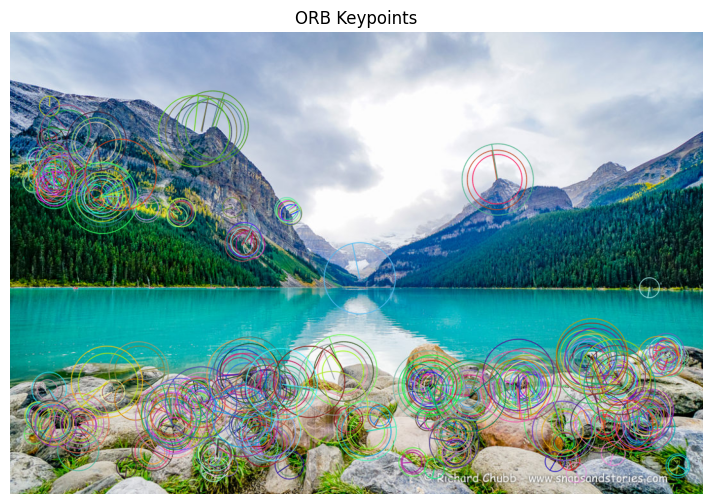

In [10]:
kp_left, kp_right, img_keypoints = utils.get_keypoint_positions(img, depth, \
                                                 num_to_include=100, fov=60, \
                                                 shift=0.063)

# Display the image with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(img_keypoints, cmap='gray')
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()

(720, 1080, 3)


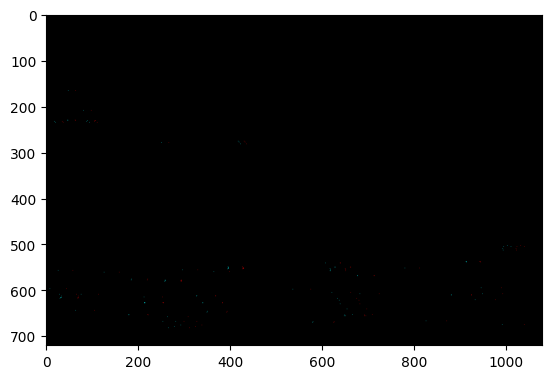

In [11]:
empty = np.zeros(img.shape)
print(img.shape)
for (j, i) in kp_left:
    empty[int(i)][int(j)] = [1, 0, 0]
for (j, i) in kp_right:
    empty[int(i)][int(j)] = [0, 1, 1]
plt.imshow(empty)

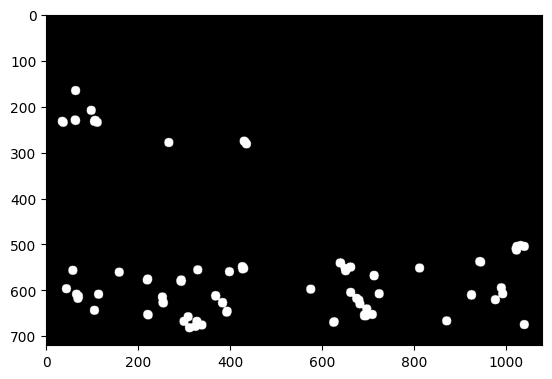

In [12]:
kp_left_img = utils.get_keypoint_image(img.shape, kp_left)
plt.imshow(kp_left_img)

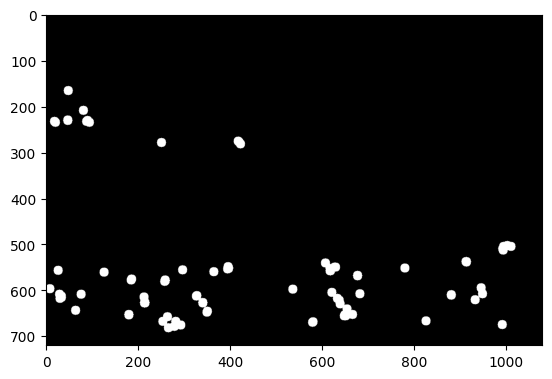

In [13]:
kp_right_img = utils.get_keypoint_image(img.shape, kp_right)
plt.imshow(kp_right_img)

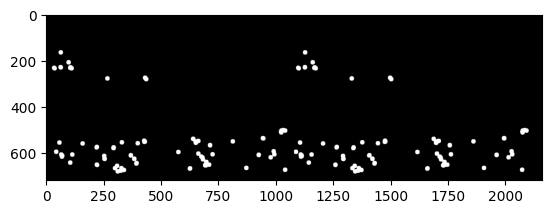

In [14]:
percept_side_by_side = np.hstack((kp_left_img, kp_right_img))
plt.imshow(percept_side_by_side, cmap='gray')

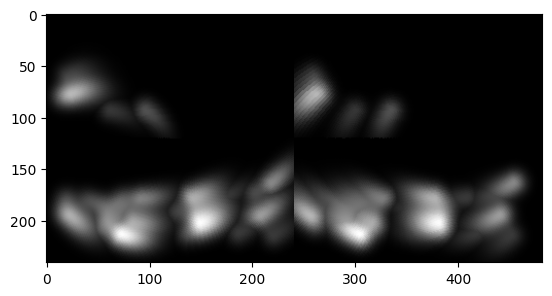

In [23]:
# map these key points onto electodes
# dumb way: use the image as a stimulus
# smart way: use the keypoints to trigger particular electrodes
# try both of these with big_prosthetic and argusII. 

# image stim big prosthetic - sort of works
keypoints_big_left = utils.get_percept_data_from_image(kp_left_img, axon_left, big_prosthetic_left)
keypoints_big_right = utils.get_percept_data_from_image(kp_right_img, axon_right, big_prosthetic_right)
percept_side_by_side = np.hstack((keypoints_big_left, keypoints_big_right))
plt.imshow(percept_side_by_side, cmap='gray')

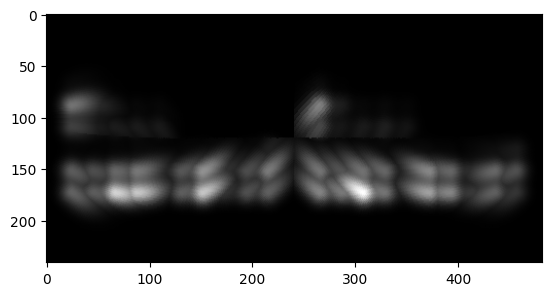

In [24]:
# image stim argus II - I don't think it really works
keypoints_argus_left = utils.get_percept_data_from_image(kp_left_img, axon_left, argus_left)
keypoints_argus_right = utils.get_percept_data_from_image(kp_right_img, axon_right, argus_right)
percept_side_by_side = np.hstack((keypoints_argus_left, keypoints_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

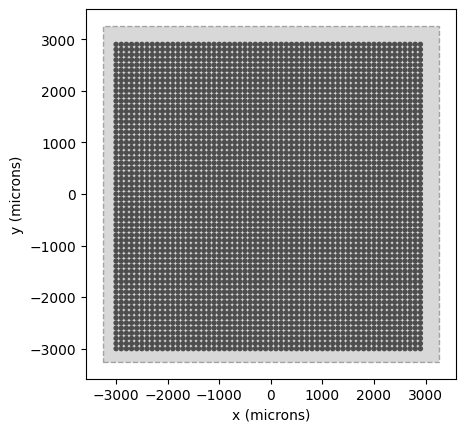

In [ ]:
scoreboard.plot()
big_prosthetic_right.plot()

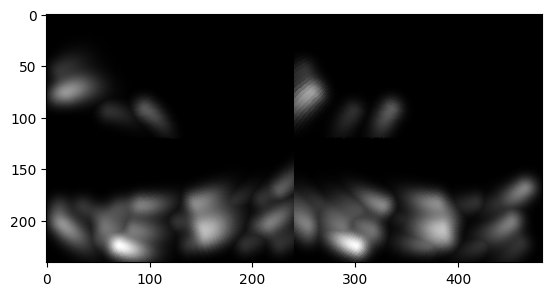

In [29]:
big_prosthetic_left.stim = utils.get_stim_from_key_points(big_prosthetic_left, kp_left, img.shape[0:2])
keypoints_smart_big_left = axon_left.predict_percept(big_prosthetic_left).data
big_prosthetic_right.stim = utils.get_stim_from_key_points(big_prosthetic_right, kp_right, img.shape[0:2])
keypoints_smart_big_right = axon_right.predict_percept(big_prosthetic_right).data
percept_side_by_side = np.hstack((keypoints_smart_big_left, keypoints_smart_big_right))
plt.imshow(percept_side_by_side, cmap='gray')

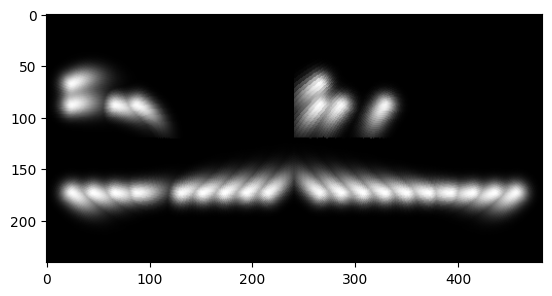

In [30]:
argus_left.stim = utils.get_stim_from_key_points(argus_left, kp_left, img.shape[0:2])
keypoints_smart_argus_left = axon_left.predict_percept(argus_left).data
argus_right.stim = utils.get_stim_from_key_points(argus_right, kp_right, img.shape[0:2])
keypoints_smart_argus_right = axon_right.predict_percept(argus_right).data
percept_side_by_side = np.hstack((keypoints_smart_argus_left, keypoints_smart_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')